# Chapter 6 - 일급 함수 디자인 패턴

## 6.1 사례: 전략 패턴의 리팩토링

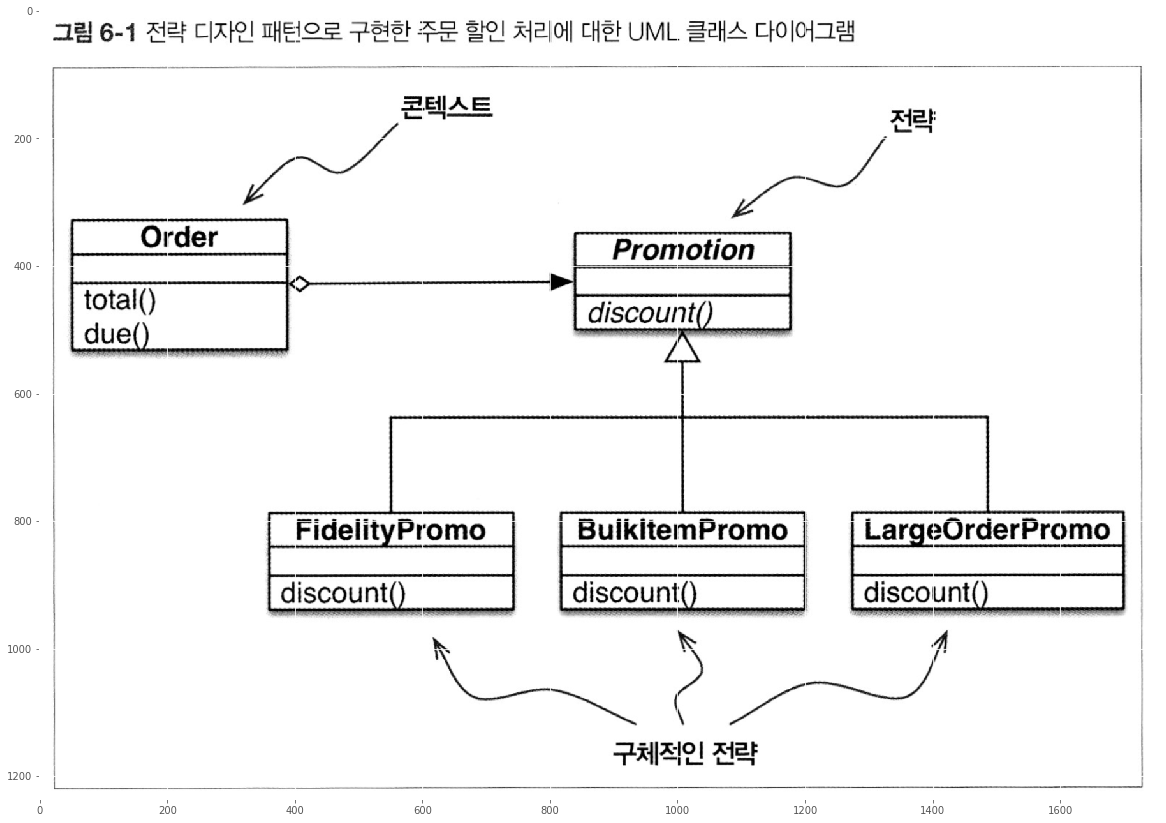

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,20))
img=mpimg.imread('strategy.png')
imgplot = plt.imshow(img)

## 6.1.1 고전적인 전략
* 구성
    * 콘텍스트 : Order
    * 전략 : Promotion
    * 구체적인 전략 : FidelityPromo

In [1]:
from abc import ABC, abstractmethod
from collections import namedtuple

Customer = namedtuple('Customer', ['name', 'fidelity'])

class LineItem(object):
    
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
        
    def total(self):
        return self.price * self.quantity
    
    
class Order(object):
    
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = cart
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due:{:.2f}>'
        return fmt.format(self.total(), self.due())
    
    
class Promotion(ABC):
    
    @abstractmethod
    def discount(self, order):
        pass
    

class FidelityPromo(Promotion):
    
    def discount(self, order):
        return order.total() * .05 if order.customer.fidelity >= 1000 else 0
    
    
class BulkItemPromo(Promotion):
    
    def discount(self, order):
        discount = 0
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * .1        
        return discount
    
    
class LargeOrderPromo(Promotion):
    
    def discount(self, order):
        distinct_items = {item.product for item in order.cart}
        if len(distinct_items) >= 10:
            return order.total() * .07
        return 0

In [2]:
# 이름, 충성도
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)

# 상품, 갯수, 가격
cart = [
    LineItem('banana', 4, .5),
    LineItem('apple', 10, 1.5),
    LineItem('watermellon', 5, 5.0),
]

# 고객, 장바구니, 프로모션
# FidelityPromo: 충성도 1000 이상이면 5% 할인
print(Order(joe, cart, FidelityPromo()))
print(Order(ann, cart, FidelityPromo()))

<Order total: 42.00 due:42.00>
<Order total: 42.00 due:39.90>


In [3]:
banana_cart = [
    LineItem('banana', 30, .5),
    LineItem('apple', 10, 1.5),
]
# BulkItemPromo: 특정 상품 20개 이상 주문하면 해당 상품 10% 할인
print(Order(joe, banana_cart, BulkItemPromo()))

<Order total: 30.00 due:28.50>


In [4]:
long_order = [
    LineItem(str(item_code), 1, 1.0)
    for item_code in range(10)
]

# LargeOrderPromo: 10종류 이상 구매하면 7% 할인
print(Order(joe, long_order, LargeOrderPromo()))
print(Order(joe, cart, LargeOrderPromo()))

<Order total: 10.00 due:9.30>
<Order total: 42.00 due:42.00>


## 6.1.2 함수 지향 전략
* 추상 클래스에서 메소드를 하나만 구현하는 것은 일반 함수로 구현하는게 좋다.

In [5]:
Customer = namedtuple('Customer', ['name', 'fidelity'])

class LineItem(object):
    
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
        
    def total(self):
        return self.price * self.quantity
    
    
class Order(object):
    
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = cart
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            # main differene
            discount = self.promotion(self)
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due:{:.2f}>'
        return fmt.format(self.total(), self.due())    


def fidelity_promo(order):
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0
    
        
def bulk_item_promo(order):
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1        
    return discount
    
    
def large_order_promo(order):
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

In [6]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)

cart = [
    LineItem('banana', 4, .5),
    LineItem('apple', 10, 1.5),
    LineItem('watermellon', 5, 5.0),
]

print(Order(joe, cart, fidelity_promo))
print(Order(ann, cart, fidelity_promo))

<Order total: 42.00 due:42.00>
<Order total: 42.00 due:39.90>


In [7]:
banana_cart = [
    LineItem('banana', 30, .5),
    LineItem('apple', 10, 1.5),
]

print(Order(joe, banana_cart, bulk_item_promo))

<Order total: 30.00 due:28.50>


In [8]:
long_order = [
    LineItem(str(item_code), 1, 1.0)
    for item_code in range(10)
]

print(Order(joe, long_order, large_order_promo))
print(Order(joe, cart, large_order_promo))

<Order total: 10.00 due:9.30>
<Order total: 42.00 due:42.00>


## 6.1.3 최선의 전략 선택하기: 단순한 접근법

In [9]:
promos = [fidelity_promo, bulk_item_promo, large_order_promo]

def best_promo(order):
    return max(promo(order) for promo in promos)

In [10]:
print(Order(joe, long_order, best_promo))

<Order total: 10.00 due:9.30>


In [11]:
print(Order(joe, banana_cart, best_promo))

<Order total: 30.00 due:28.50>


In [12]:
print(Order(ann, cart, best_promo))

<Order total: 42.00 due:39.90>


In [13]:
promos = [globals()[name] for name in globals() if name.endswith('_promo') and name != 'best_promo']

In [14]:
for p in promos:
    print(p.__name__)

fidelity_promo
bulk_item_promo
large_order_promo


In [1]:
import inspect
import promotions

promos = [func for name, func in inspect.getmembers(promotions, inspect.isfunction)]

In [5]:
for p in promos:
    print(p.__name__)

bulk_item_promo
fidelity_promo
large_order_promo


In [3]:
! cat promotions.py

def fidelity_promo(order):
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0


def bulk_item_promo(order):
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount


def large_order_promo(order):
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

In [4]:
for name, f in inspect.getmembers(promotions, inspect.isfunction):
    print(name, ':', f)

bulk_item_promo : <function bulk_item_promo at 0x111dd5378>
fidelity_promo : <function fidelity_promo at 0x111df3ea0>
large_order_promo : <function large_order_promo at 0x111dd5488>


## 6.2 명령

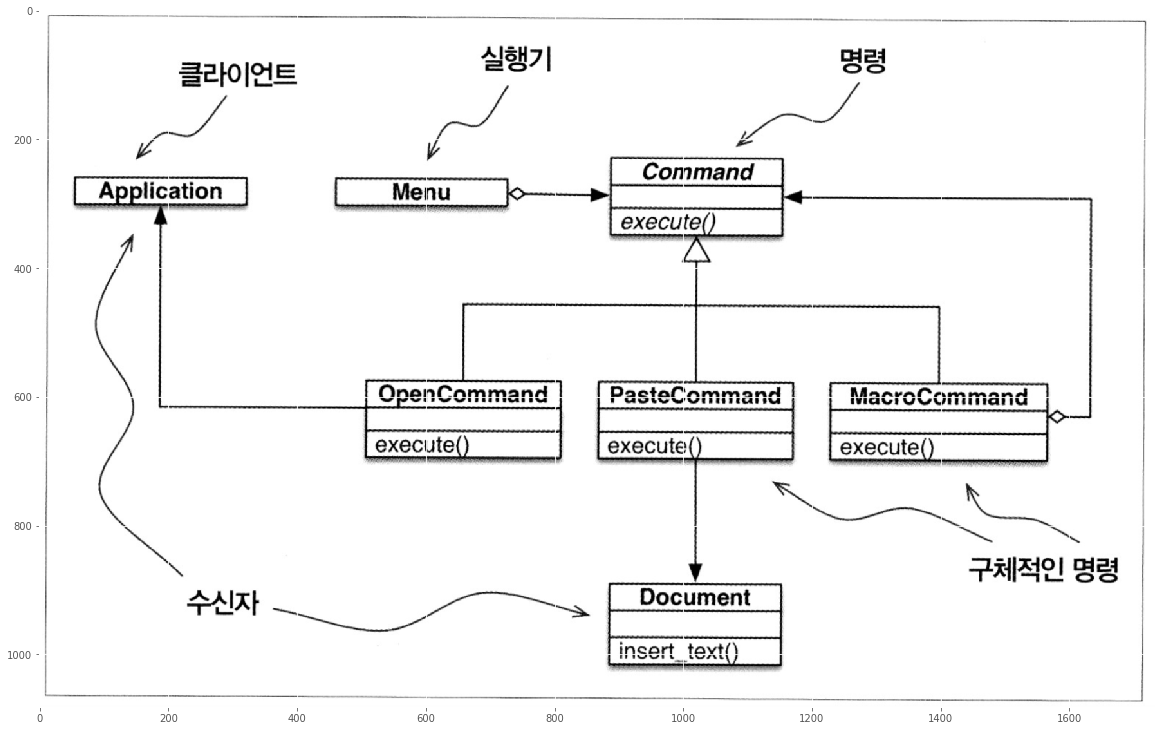

In [20]:
plt.figure(figsize=(20,20))
img=mpimg.imread('command.png')
imgplot = plt.imshow(img)

In [21]:
class MacroCommand:
    
    def __init__(self, commands):
        self.commands = commands
        
    def __call__(self):
        for command in self.commands:
            command()